# EXA Series, Prototype 014-D

## Introduction

EXA series correspond to only unsupervised learning and technical analysis, which means there will be no fundamental analysis, portfolio optimization and performance evolution or financial feature engineering for alpha factor research. 
Prototype 014 is a use case of Advantage Actor Critic (A2C), and 014D has an addition of simple TA tools like SMA or RSI.

In [3]:
import tensorflow as tf
import gym
import gym_anytrading
from gym_anytrading.envs import StocksEnv

from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C
from finta import TA

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('dark_background')

import warnings
warnings.filterwarnings("ignore")

## FSTE DATA import

In [4]:
data = pd.read_csv('/kaggle/input/ftsedata/ftse.csv', index_col='Date', parse_dates=True)
df = data.copy()
df.sort_values('Date', ascending=True, inplace=True)
df = df.applymap(lambda x: float(x.replace(',','')))
df

,Open,High,Low,Close
Date,,,,
2022-02-03,7583.00,7605.75,7528.69,7528.84
2022-02-04,7528.84,7599.73,7497.21,7516.40
2022-02-07,7516.40,7591.65,7508.48,7573.47
2022-02-08,7573.47,7631.31,7548.19,7567.07
2022-02-09,7567.07,7657.93,7567.07,7643.42
...,...,...,...,...
2023-01-30,7765.15,7790.69,7718.33,7784.87
2023-01-31,7784.87,7784.87,7708.34,7771.70
2023-02-01,7771.70,7798.51,7745.43,7761.11


In [5]:
#searching for custom indicators: SMA x RSI
df['SMA'] = TA.SMA(df, 7)
df['RSI'] = TA.RSI(df)
df = df.fillna(0)
df

,Open,High,Low,Close,SMA,RSI
Date,,,,,,
2022-02-03,7583.00,7605.75,7528.69,7528.84,0.000000,0.000000
2022-02-04,7528.84,7599.73,7497.21,7516.40,0.000000,0.000000
2022-02-07,7516.40,7591.65,7508.48,7573.47,0.000000,83.166441
2022-02-08,7573.47,7631.31,7548.19,7567.07,0.000000,75.575654
2022-02-09,7567.07,7657.93,7567.07,7643.42,0.000000,88.758046
...,...,...,...,...,...,...
2023-01-30,7765.15,7790.69,7718.33,7784.87,7766.945714,62.350630
2023-01-31,7784.87,7784.87,7708.34,7771.70,7767.104286,60.302403
2023-02-01,7771.70,7798.51,7745.43,7761.11,7763.738571,58.634446


In [27]:
def add_signal(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1] #taking starting/ending indexes
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Low', 'SMA', 'RSI']].to_numpy()[start:end]
    return prices, signal_features

class CustomEnv(StocksEnv):
    _process_data = add_signal
    
env2 = CustomEnv(df=df, window_size=12, frame_bound=(12, 100))
print(env2.prices)
df.head(15)

[7528.69 7497.21 7508.48 7548.19 7567.07 7622.74 7596.11 7483.36 7513.16
 7560.94 7499.86 7508.73 7446.43 7365.04 7490.54 7204.74 7207.38 7361.59
 7327.79 7320.77 7231.51 6980.86 6787.98 6893.55 6964.11 7065.96 7099.03
 7143.95 7075.82 7175.7  7260.51 7318.9  7402.6  7442.39 7459.36 7453.25
 7441.28 7471.47 7473.14 7523.82 7515.68 7508.92 7532.23 7536.21 7536.2
 7537.25 7551.81 7611.68 7543.03 7550.94 7551.39 7565.81 7590.62 7596.29
 7521.68 7339.53 7380.54 7344.89 7425.61 7509.19 7475.69 7493.45 7493.45
 7354.06 7216.58 7216.58 7238.97 7158.53 7233.34 7361.72 7464.8  7438.09
 7228.67 7302.74 7389.98 7434.46 7484.35 7512.45 7542.78 7576.37 7591.84
 7529.23 7532.84 7570.67 7550.65 7472.29 7294.2  7174.02 7135.15 7186.5
 7039.47 6998.17 7016.15 7119.25 7030.03 7014.19 7016.02 7208.52 7258.32
 7263.54]


,Open,High,Low,Close,SMA,RSI
Date,,,,,,
2022-02-03,7583.00,7605.75,7528.69,7528.84,0.000000,0.000000
2022-02-04,7528.84,7599.73,7497.21,7516.40,0.000000,0.000000
2022-02-07,7516.40,7591.65,7508.48,7573.47,0.000000,83.166441
2022-02-08,7573.47,7631.31,7548.19,7567.07,0.000000,75.575654
2022-02-09,7567.07,7657.93,7567.07,7643.42,0.000000,88.758046
2022-02-10,7643.42,7687.27,7622.74,7672.40,0.000000,90.789966
2022-02-11,7672.40,7672.40,7596.11,7661.02,7594.660000,84.343180
2022-02-14,7661.02,7661.02,7483.36,7531.59,7595.052857,45.109897
2022-02-15,7531.59,7608.92,7513.16,7608.92,7608.270000,57.754000


## Build Env & Gym train 
-------

In [28]:
env_maker = lambda: env2
env = DummyVecEnv([env_maker])

model_a2c = A2C('MlpPolicy', env, verbose=1) 
model_a2c.learn(total_timesteps=1000000)

Using cpu device
------------------------------------
| time/                 |          |
|    fps                | 752      |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.401   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -45.2    |
|    value_loss         | 1.16e+04 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 753      |
|    iterations         | 200      |
|    time_elapsed       | 1        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.247   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss        | 0.000174 |
|    value_loss      

KeyboardInterrupt: 

________________________________________________________________________________________________
Info: {'total_reward': 256.2500000000018, 'total_profit': 0.8629794641358763, 'position': 1}
________________________________________________________________________________________________


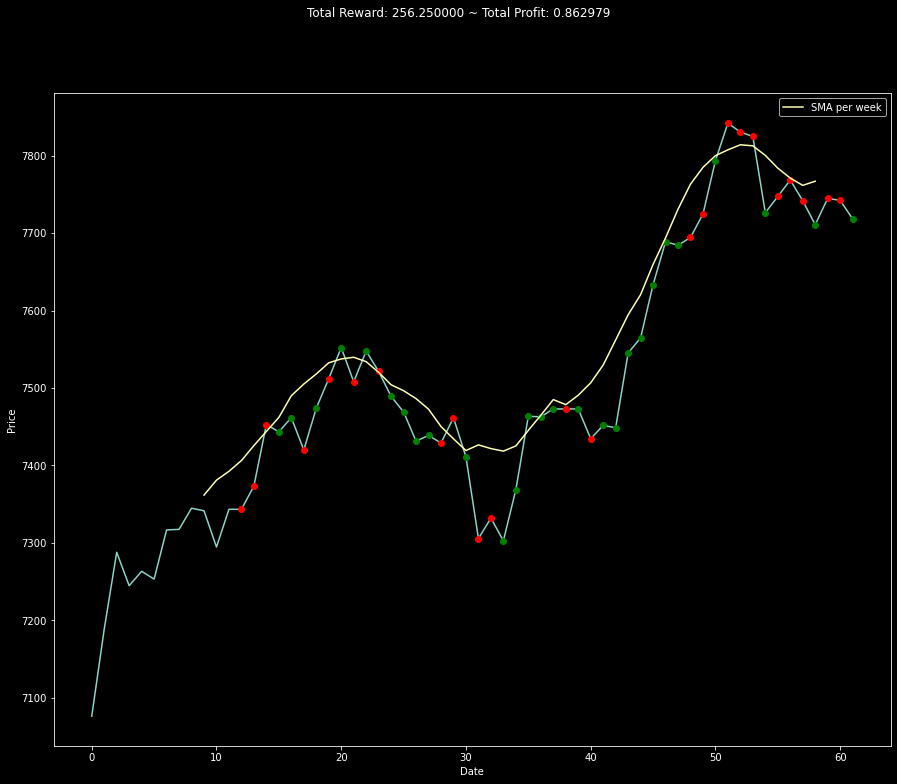

In [67]:
env = CustomEnv(df=df, window_size=12, frame_bound=(200,250))
observ = env.reset()
while True: 
    observ = observ[np.newaxis, ...]
    action, _states = model_a2c.predict(observ)
    observ, rewards, done, info = env.step(action)
    if done:
        print('________________________________________________________________________________________________')
        print(f'Info: {info}')
        print('________________________________________________________________________________________________')
        break
        

plt.figure(figsize=(15, 12))            
env.render_all(mode='human')
#df.loc["11/2022":, 'SMA'].plot(label='SMA')
dfma = df.copy()
dfma['index'] = np.array([i - 191 for i in range(len(dfma['SMA']))])
plt.plot(dfma['index'][200: 250], dfma['SMA'][200:250], label='SMA per week')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

## Conclusion
-------
EXA014D was significally worse than his collegues EXA014-A,B,C. Whatever the interval is put, the profit will always be negative (zBs. for the time frame of 200-250, a total loss of approx 14%). This is explainable by the fact that an unsupervised model can be easily overfitted or underfitted, and at the same time, it is all about the technical analysis, which is a worse technique than a coin toss. Please note that for these series, we didn't have the 'Volume' column, which could be a source for other TA indicators (zBs. OBV) 

This model will conclude the EXA014 series, before going for FAS series. 

----

###### N.B. All models from EXA series has an unique academic goal. Do not take as a financial advice. 